In [21]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

np.random.seed(72)
torch.manual_seed(72)
device = 'mps'

In [22]:
# Data

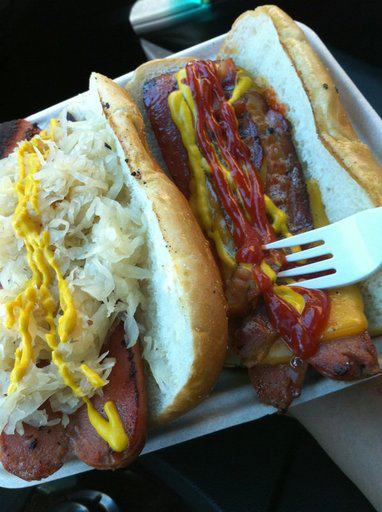

In [23]:
from PIL import Image
from IPython.display import display
img = Image.open("./data/Foods/train/food/1_172.jpg")
display(img) # images in Python are PIL images

In [24]:
from torchvision import transforms # 防止食物图片不在我们所聚焦的区域内
train_transform = transforms.Compose([
    transforms.Resize(256), # 缩放
    transforms.RandomResizedCrop(224), # 随机获取224*224的图片矩阵
    transforms.CenterCrop(224), # 224 * 224 the size needed bu the model I am going to use
    transforms.ColorJitter(),
    transforms.RandomRotation(degrees=15),
    
    transforms.ToTensor(),
    transforms.Normalize([0.48, 0.44, 0.4], [0.22, 0.22, 0.22]) # **
])

In [25]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(root="./data/Foods/train", transform=train_transform)

In [26]:
len(train_dataset)

3000

In [27]:
img, lbl = train_dataset[4]
img.size, lbl

(<function Tensor.size>, 0)

In [28]:
type(img), type(lbl)

(torch.Tensor, int)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


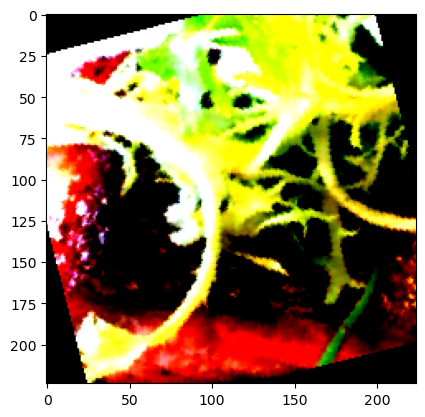

In [29]:
plt.imshow(img.permute(1, 2, 0))

# if img is PIL Image --> display(img)
# if img is tensor --> plt.imshow() #
# plt imshow expects the inputs of size h*w*c

In [30]:
# Train / val split

In [31]:
train_dataset, val_dataset = random_split(train_dataset, [2500, 500])

len(train_dataset), len(val_dataset) # after train/val split

(2500, 500)

In [32]:
# Data loeader

In [33]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128)
val_loader = DataLoader(dataset=val_dataset, batch_size=128)

In [34]:
# Model

In [35]:
from torchvision import models
vgg16_model = models.vgg16(weights = "DEFAULT")

In [36]:
class MyVGGModel(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16_model = models.vgg16(weights = "DEFAULT")
        self.features = vgg16_model.features
        self.avgpool = vgg16_model.avgpool
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(25088, 500),  # 512 * 7 * 7
            nn.Linear(500, 1)
        )
        
    def forward(self, x):
        out = self.features(x)
        out = self.avgpool(out)
        out = self.fc(out)
        
        return out
    
tmpModel = MyVGGModel().to(device)
tmpImg, _ = next(iter(train_loader))
tmpImg = tmpImg.to(device)
tmpOut = tmpModel(tmpImg)
tmpOut.shape

torch.Size([128, 1])

In [37]:
# Freezing the features layers weights
model = MyVGGModel().to(device)
# print(model)

for params in model.features.parameters():
    # print(params.shape)
    # print(params.requires_grad)
    params.requires_grad = False
print("Done")

Done


In [38]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100 
    return acc

In [39]:
# Model training

In [40]:
train_losses = []; train_accs = []
validation_losses = []; validation_accs = []

lr = 0.001
n_epochs = 10

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=lr)

for epoch in range(n_epochs):
    # Training Loop
    model.train()
    train_loss, train_acc = 0, 0
    
    for x_batch, y_batch in train_loader: 
            
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device).float()
        
        y_logits = model(x_batch).squeeze() # squeeze to remove extra `1` dimensions,
        loss = loss_fn(y_logits, y_batch)
        
        train_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()    
        optimizer.step()
        
        y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels
        train_acc += accuracy_fn(y_true=y_batch, y_pred=y_pred) 
        
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    train_acc /= len(train_loader)
    train_accs.append(train_acc)
    
    # Validation Loop
    model.eval()
    validation_loss , validation_acc = 0, 0
    
    with torch.no_grad():
        for x_val, y_val in val_loader:

            x_val = x_val.to(device)
            y_val = y_val.to(device).float()

            y_logits = model(x_val).squeeze()
            val_loss = loss_fn(y_logits, y_val)
            
            validation_loss += val_loss.item()
            
            y_pred = torch.round(torch.sigmoid(y_logits)) 
            validation_acc += accuracy_fn(y_true=y_val, y_pred=y_pred) 
        
    validation_loss /= len(val_loader)
    validation_losses.append(validation_loss)
    
    validation_acc /= len(val_loader)
    validation_accs.append(validation_acc)
    
    # Print out what's happening every 10 epochs
    if epoch % 1 == 0:
        print(f"Epoch: {epoch} | Loss: {train_loss:.5f}, Accuracy: {train_acc:.2f}% | val loss: {validation_loss:.5f}, val acc: {validation_acc:.2f}%")

Epoch: 0 | Loss: 0.55354, Accuracy: 77.08% | val loss: 0.43692, val acc: 89.13%
Epoch: 1 | Loss: 0.37767, Accuracy: 91.70% | val loss: 0.33504, val acc: 92.20%
Epoch: 2 | Loss: 0.30928, Accuracy: 92.42% | val loss: 0.29975, val acc: 90.17%
Epoch: 3 | Loss: 0.26739, Accuracy: 93.71% | val loss: 0.25531, val acc: 93.82%
Epoch: 4 | Loss: 0.24307, Accuracy: 94.63% | val loss: 0.23459, val acc: 93.82%
Epoch: 5 | Loss: 0.22043, Accuracy: 94.51% | val loss: 0.22274, val acc: 94.43%
Epoch: 6 | Loss: 0.21326, Accuracy: 94.06% | val loss: 0.21377, val acc: 93.96%
Epoch: 7 | Loss: 0.19531, Accuracy: 94.51% | val loss: 0.19863, val acc: 94.59%
Epoch: 8 | Loss: 0.18675, Accuracy: 95.06% | val loss: 0.18836, val acc: 94.92%
Epoch: 9 | Loss: 0.17795, Accuracy: 95.26% | val loss: 0.18368, val acc: 94.39%


In [41]:
# Plot

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(train_losses,  label="train loss"); 
ax[0].plot(validation_losses,  label="val loss"); 
ax[0].legend();

ax[1].plot(train_accs,  label="train acc");
ax[1].plot(validation_accs,  label="val acc"); 
ax[1].legend();

In [ ]:
# Test model with an input image

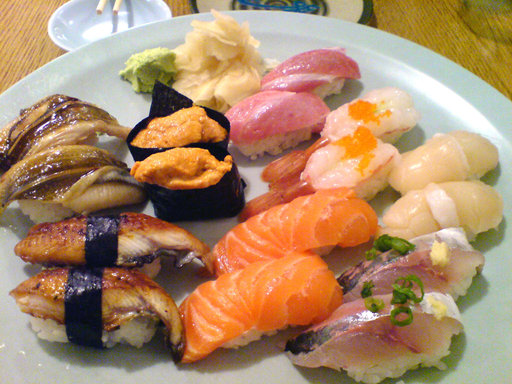

In [42]:
img_test = Image.open("./data/Foods/test/food/1_4.jpg")
img_test

In [43]:
test_transform = transforms.Compose([
    transforms.Resize(256), # 缩放
    transforms.RandomResizedCrop(224), # 随机获取224*224的图片矩阵
    transforms.ToTensor(),
    transforms.Normalize([0.48, 0.44, 0.4], [0.22, 0.22, 0.22]) # **
    
])

In [46]:
# Convert it to tensor
img_test_tensor = test_transform(img_test).unsqueeze(0)
img_test_tensor.shape

torch.Size([1, 3, 224, 224])

In [47]:
y_logits = model(img_test_tensor.to(device))